In [2]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math
#import data_preprocessing as dp


import matplotlib.pyplot as plt
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
import cv2
#from resnet_utils import *

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


################# prepare data #################
'''
load dataset
normalize
dummy variables (encode y)
constants

'''

################ model training #################
'''
build up architecture


'''


'''
load dataset from folder
'''
def load_dataset():
    train_dataset = h5py.File('./training-data-0528.h5', "r")
    train_set_x_orig = np.array(train_dataset['X'][:])
    train_set_y_orig = np.array(train_dataset["y"][:])

    test_dataset = h5py.File('./testing-data-0528.h5', "r")
    test_set_x_orig = np.array(test_dataset['X'][:])
    test_set_y_orig = np.array(test_dataset["y"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder(name="x", dtype=tf.float32, shape=(12288, 1))
    var = tf.get_variable("weights", dtype=tf.float32, shape=(12288, 1))
    val = img + var
    out = tf.identity(val, name="out")
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
    
    converter = tf.lite.TFLiteConverter.from_session(sess, [x], [out])
    tflite_model = converter.convert()
    open("converted_model.tflite", "wb").write(tflite_model)
        
    return prediction



'''
normalize the image data
'''
def normalize():
    # Normalize image vectors
    X_train = X_train_orig/255.
    X_test = X_test_orig/255.
    return X_train, X_test
    
'''
one hot encoding y labels
'''
def encode_y():
    Y_train = convert_to_one_hot(Y_train_orig, 3).T
    Y_test = convert_to_one_hot(Y_test_orig, 3).T
    return Y_train, Y_test
    
def check_shape():
    print ("number of training examples = " + str(X_train.shape[0]))
    print ("number of test examples = " + str(X_test.shape[0]))
    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))
    
    
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()
normalize()

X_train, X_test = normalize()
Y_train, Y_test = encode_y()

img_height,img_width = 64,64 
num_classes = 3

base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))    

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)    
    
from keras.optimizers import SGD, Adam
sgd = SGD(lr=0.001, momentum=0.9, nesterov=False)
# adam = Adam(lr=0.0001)
model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['accuracy'])



W0617 17:53:06.860518 140308561700736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 17:53:06.892981 140308561700736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 17:53:06.902336 140308561700736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0617 17:53:06.936290 140308561700736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 17:53:06.937262

In [3]:
history = model.fit(X_train, Y_train , validation_split=0.2, epochs = 200, batch_size = 64)

W0617 17:53:29.655621 140308561700736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1618 samples, validate on 405 samples
Epoch 1/200
1618/1618 [==============================] - 16s 10ms/step - loss: 1.6509 - acc: 0.5667 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/200
1618/1618 [==============================] - 3s 2ms/step - loss: 1.2988 - acc: 0.5989 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/200
1618/1618 [==============================] - 3s 2ms/step - loss: 1.1203 - acc: 0.6224 - val_loss: 14.2407 - val_acc: 0.0198
Epoch 4/200
1618/1618 [==============================] - 3s 2ms/step - loss: 1.0060 - acc: 0.6514 - val_loss: 11.8548 - val_acc: 0.0272
Epoch 5/200
1618/1618 [==============================] - 3s 2ms/step - loss: 0.8827 - acc: 0.6749 - val_loss: 6.9360 - val_acc: 0.2123
Epoch 6/200
1618/1618 [==============================] - 3s 2ms/step - loss: 0.8289 - acc: 0.7114 - val_loss: 4.8961 - val_acc: 0.3012
Epoch 7/200
1618/1618 [==============================] - 3s 2ms/step - loss: 0.6924 - acc: 0.7454 - val_loss: 2.7913 - val_acc: 0

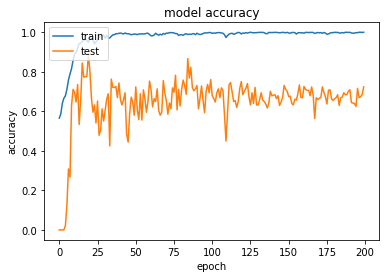

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:

preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

504/504 [==============================] - 1s 2ms/step
Loss = 1.1401852719367496
Test Accuracy = 0.811507935561831


In [0]:
keras_file = "keras_model.h5"
model.save(keras_file)